In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from keras.models import Sequential
from keras import layers
from keras.layers import Embedding

import seaborn as sns
sns.set(style = 'whitegrid')

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix

In [134]:
df = pd.read_csv('../Clean_Dataset.csv', encoding='UTF-8')

In [135]:
train = df[['Clean_Text','Stop_Words_Text', 'Stemmed_Text', 'indonlp_sentiment', 'Lexicon_Score']]

In [136]:
len(df['Clean_Text'])

42403

#### Data Preprocessing

In [158]:
data = df['Clean_Text'].values.tolist()

In [159]:
print(data[:5])

['cina dan as terus bersaing mengembangkan teknologi terbaru termasuk kali ini perusahaan di kedua negara berlomba lomba membangun dunia virtual atau metaverse', 'katanya mau metaverse tapi down melulu bagaimana mas zuck', 'mungkin facebook sudah berencana menjadi metaverse besar secara sudah menyiapkan diem sebagai stable currency mereka kalau emang iya pasti nanti pindah ke blokchain semua facebook masih menang banyak karena hanya memerlukan pembaruan teknologi penggunanya sudah banyak', 'bersaing dengan perusahaan kelas dunia untuk mencapai hal ini sektor publik dan swasta harus bersatu untuk membentuk ekosistem metaverse yang melibatkan teknologi ar vr dan xr dalam forum tersebut juga dibahas bagaimana mensukseskan platform ini dengan pasar konsumen', 'metaverse belum diadaptasi masif masih terus dikembangkan nyatanya hari ini kita kadang sudah bingung ujung pangkal dari persinggugangan realita empiris dan realita artifisial waw']


### Building a Model

#### Label Encoding of Output

In [160]:
import tensorflow as tf
labels = np.array(train['indonlp_sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

#### Tokenizing and Adding Padding

In [161]:
max_words = 50000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
X = pad_sequences(sequences, maxlen=max_len)
print(X)

[[    0     0     0 ...    30    44     1]
 [    0     0     0 ...    62   220  1546]
 [    0     0     0 ...  1595    10    47]
 ...
 [    0     0     0 ...  2031    42  3086]
 [    0     0     0 ...  1950   744 15685]
 [    0     0     0 ...   199     2   638]]


In [162]:
scaler = MinMaxScaler()

In [163]:
# extract sentiment scores
sentiment_scores = df['Lexicon_Score'].values

# perform min-max scaling on sentiment scores
scaler = MinMaxScaler()
sentiment_scaled = scaler.fit_transform(sentiment_scores.reshape(-1, 1))

df['Sentiment_Scaled'] = sentiment_scaled 

In [164]:
df['Sentiment_Scaled']

0        0.585938
1        0.500000
2        0.703125
3        0.578125
4        0.625000
           ...   
42398    0.476562
42399    0.523438
42400    0.492188
42401    0.453125
42402    0.531250
Name: Sentiment_Scaled, Length: 42403, dtype: float64

In [165]:
#Combine sentiment scores with text data
X = np.hstack((sentiment_scaled, X))
y = labels

In [166]:
print(X.shape)

(42403, 101)


In [167]:
X = X[:, :-1]

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(33922, 100) (33922, 3)
(8481, 100) (8481, 3)


#### Using BiDirectional RNN and LSTM

In [148]:
embedding_layer = Embedding(1000, 64)

In [100]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

#### Train the Model

In [101]:
history = model2.fit(X_train, y_train, epochs=10,validation_split=0.2)

Epoch 1/10
849/849 [==============================] - 64s 69ms/step - loss: 0.7007 - accuracy: 0.7028 - val_loss: 0.6007 - val_accuracy: 0.7548
Epoch 2/10
849/849 [==============================] - 56s 66ms/step - loss: 0.4774 - accuracy: 0.8100 - val_loss: 0.5140 - val_accuracy: 0.7891
Epoch 3/10
849/849 [==============================] - 55s 65ms/step - loss: 0.3669 - accuracy: 0.8560 - val_loss: 0.5199 - val_accuracy: 0.7913
Epoch 4/10
849/849 [==============================] - 55s 65ms/step - loss: 0.2933 - accuracy: 0.8878 - val_loss: 0.5436 - val_accuracy: 0.7867
Epoch 5/10
849/849 [==============================] - 54s 64ms/step - loss: 0.2513 - accuracy: 0.9034 - val_loss: 0.5885 - val_accuracy: 0.7926
Epoch 6/10
849/849 [==============================] - 53s 63ms/step - loss: 0.2160 - accuracy: 0.9196 - val_loss: 0.6473 - val_accuracy: 0.7863
Epoch 7/10
849/849 [==============================] - 56s 65ms/step - loss: 0.1889 - accuracy: 0.9291 - val_loss: 0.6790 - val_accuracy:

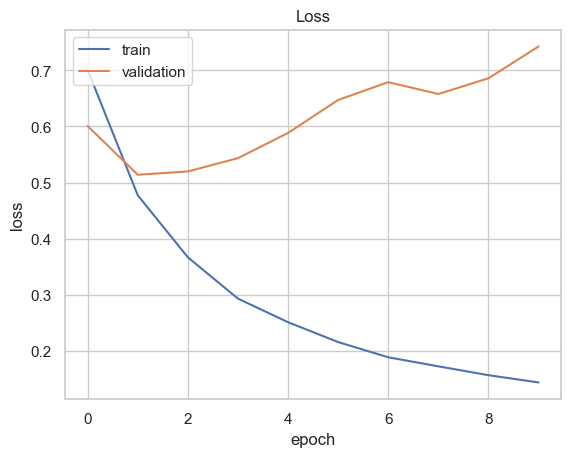

In [102]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

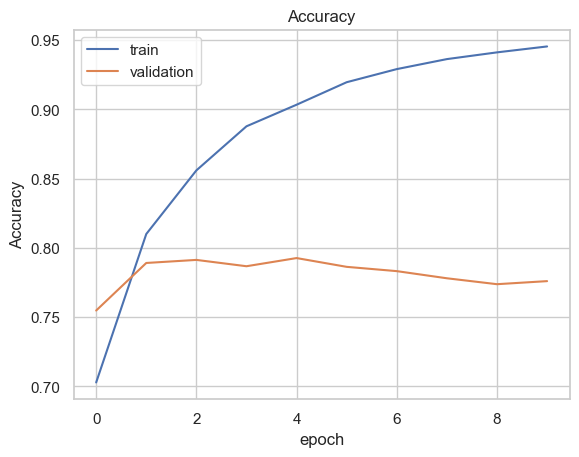

In [103]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

266/266 [==============================] - 4s 10ms/step
Model Accuracy on Test Data: 0.769602641197972


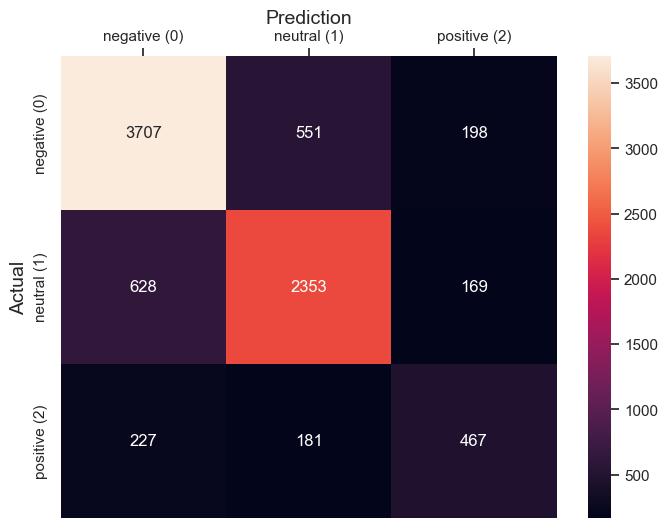

In [104]:
# Predict sentiment on data test by using model has been created, and then visualize a confusion matrix
y_pred = np.argmax(model2.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print('Model Accuracy on Test Data:', accuracy)
confusion_matrix(y_true=y_true, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true=y_true, y_pred=y_pred), fmt='g', annot=True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize=14)
ax.set_xticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
ax.set_ylabel('Actual', fontsize=14)
ax.set_yticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
plt.show()


In [105]:
# predict classes for test set
y_pred = np.argmax(model2.predict(X_test), axis=-1)

# convert one-hot encoded true labels to integer class labels
y_test_int = np.argmax(y_test, axis=1)

# calculate metrics
print(classification_report(y_test_int, y_pred))

# calculate confusion matrix
conf_mat = confusion_matrix(y_test_int, y_pred)
print(conf_mat)


266/266 [==============================] - 3s 10ms/step
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      4456
           1       0.76      0.75      0.75      3150
           2       0.56      0.53      0.55       875

    accuracy                           0.77      8481
   macro avg       0.71      0.70      0.71      8481
weighted avg       0.77      0.77      0.77      8481

[[3707  551  198]
 [ 628 2353  169]
 [ 227  181  467]]


#### Prediction and Result

In [106]:
sentiment = ['Neutral', 'Negative', 'Positive']

In [107]:
sequence = tokenizer.texts_to_sequences(['metaverse teknologi yang sangat buruk'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 35ms/step


'Negative'

In [108]:
sequence = tokenizer.texts_to_sequences(['wow metaverse teknologi yang sangat menjanjikan'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 38ms/step


'Positive'

In [109]:
sequence = tokenizer.texts_to_sequences(['kita lihat saja bagaimana perkembangan teknologi tersebut'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 38ms/step


'Neutral'

#### Building Model again with some Regularization

In [169]:
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.BatchNormalization())
model.add(layers.Bidirectional(layers.LSTM(15,dropout=0.6)))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

In [170]:
history2 = model.fit(X_train,y_train, epochs=10,validation_split=0.2)

Epoch 1/10
849/849 [==============================] - 51s 52ms/step - loss: 0.7905 - accuracy: 0.6607 - val_loss: 0.6879 - val_accuracy: 0.7324
Epoch 2/10
849/849 [==============================] - 44s 52ms/step - loss: 0.6403 - accuracy: 0.7346 - val_loss: 0.6248 - val_accuracy: 0.7593
Epoch 3/10
849/849 [==============================] - 44s 52ms/step - loss: 0.5843 - accuracy: 0.7631 - val_loss: 0.5916 - val_accuracy: 0.7633
Epoch 4/10
849/849 [==============================] - 42s 49ms/step - loss: 0.5487 - accuracy: 0.7774 - val_loss: 0.5892 - val_accuracy: 0.7692
Epoch 5/10
849/849 [==============================] - 43s 50ms/step - loss: 0.5236 - accuracy: 0.7897 - val_loss: 0.5787 - val_accuracy: 0.7789
Epoch 6/10
849/849 [==============================] - 42s 50ms/step - loss: 0.5022 - accuracy: 0.7989 - val_loss: 0.5733 - val_accuracy: 0.7711
Epoch 7/10
849/849 [==============================] - 41s 49ms/step - loss: 0.4880 - accuracy: 0.8064 - val_loss: 0.5722 - val_accuracy:

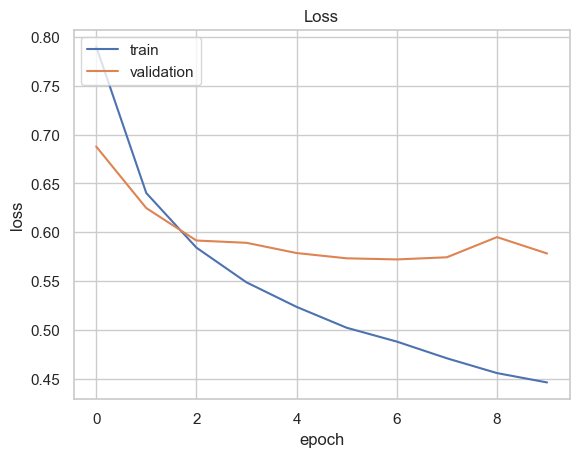

In [171]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

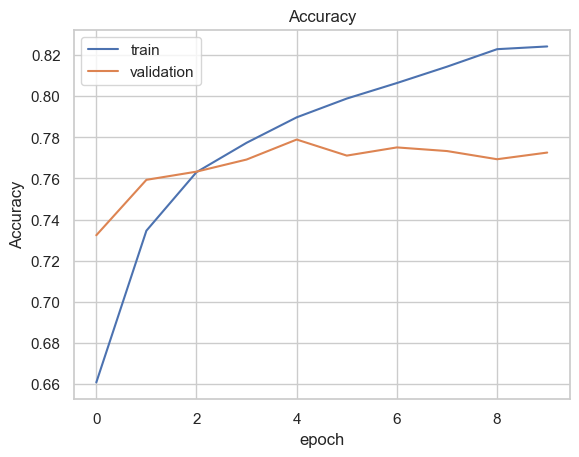

In [172]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

266/266 [==============================] - 4s 10ms/step
Model Accuracy on Test Data: 0.7666548756042919


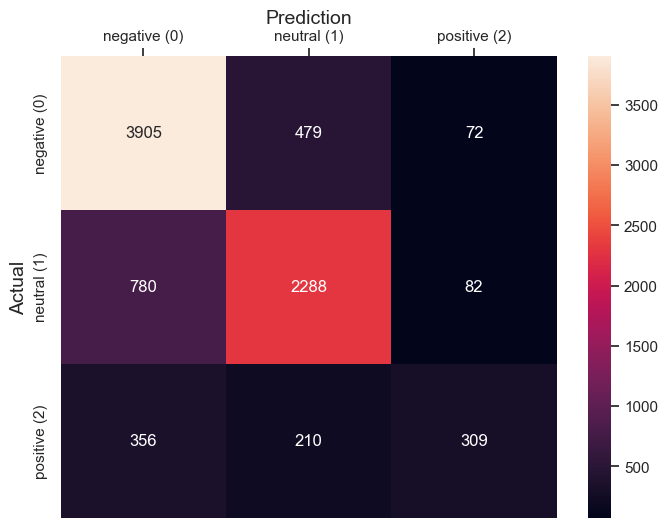

In [173]:
# Predict sentiment on data test by using model has been created, and then visualize a confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print('Model Accuracy on Test Data:', accuracy)
confusion_matrix(y_true=y_true, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true=y_true, y_pred=y_pred), fmt='g', annot=True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize=14)
ax.set_xticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
ax.set_ylabel('Actual', fontsize=14)
ax.set_yticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
plt.show()


In [174]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# predict classes for test set
y_pred = np.argmax(model.predict(X_test), axis=-1)

# convert one-hot encoded true labels to integer class labels
y_test_int = np.argmax(y_test, axis=1)

# calculate metrics
print(classification_report(y_test_int, y_pred))

# calculate confusion matrix
conf_mat = confusion_matrix(y_test_int, y_pred)
print(conf_mat)


266/266 [==============================] - 3s 11ms/step
              precision    recall  f1-score   support

           0       0.77      0.88      0.82      4456
           1       0.77      0.73      0.75      3150
           2       0.67      0.35      0.46       875

    accuracy                           0.77      8481
   macro avg       0.74      0.65      0.68      8481
weighted avg       0.76      0.77      0.76      8481

[[3905  479   72]
 [ 780 2288   82]
 [ 356  210  309]]


In [175]:
sequence = tokenizer.texts_to_sequences(['pada sadar tidak yang namanya metaverse kok kyknya bakal jadi satu kegilan baru era digital'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 39ms/step


'Negative'

In [176]:
sequence = tokenizer.texts_to_sequences(['kita lihat saja bagaimana perkembangan teknologi metaverse kedepannya'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 34ms/step


'Neutral'

In [177]:
sequence = tokenizer.texts_to_sequences(['teknologi yang sangat menjanjikan, semoga dapat diterapkan secara masif'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 35ms/step


'Positive'